# Aggregate scalar/vector results monthly
     - calculates distance from the nearest coastline
     - Record all scalar data into a single netCDF file
     - The resulting file is saved in the same folder
     - It contains the following information for each individual eddy: 
     - 'dist_to_coast'
     - 'NPP'
     - 'amplitude',
     - 'effective_area',
     - 'effective_contour_height',
     - 'effective_contour_shape_error',
     - 'effective_radius',
     - 'inner_contour_height',
     - 'latitude',
     - 'latitude_max',
     - 'longitude',
     - 'longitude_max',
     - 'num_contours',
     - 'num_point_e',
     - 'num_point_s',
     - 'speed_area',
     - 'speed_average',
     - 'speed_contour_height',
     - 'speed_contour_shape_error',
     - 'speed_radius'
     - And the following vectors
     - 'effective_contour_latitude',
     - 'effective_contour_longitude',
     - 'speed_contour_latitude',
     - 'speed_contour_longitude',
     - 'uavg_profile'

In [15]:
# --------------------------------------------------------
# import necessary packages
# --------------------------------------------------------
from matplotlib import pyplot as plt
import pandas as pd
from py_eddy_tracker import data
from py_eddy_tracker.dataset.grid import RegularGridDataset
import xarray as xr
from datetime import datetime
import numpy as np
from netCDF4 import Dataset
import warnings
warnings.filterwarnings('ignore')

In [16]:
# These need to be specified
domain='whole'
Lcutoff=300
sshmin=0.01

In [17]:
# List the name of the variables
#
Nmax = 100
vars_keep=['amplitude',
     'effective_area',
     'effective_contour_height',
     'effective_contour_shape_error',
     'effective_radius',
     'inner_contour_height',
     'latitude',
     'latitude_max',
     'longitude',
     'longitude_max',
     'num_contours',
     'num_point_e',
     'num_point_s',
     'speed_area',
     'speed_average',
     'speed_contour_height',
     'speed_contour_shape_error',
     'speed_radius']
Ns = np.size(vars_keep)
# 
vectors=['effective_contour_latitude',
         'effective_contour_longitude',
         'speed_contour_latitude',
         'speed_contour_longitude',
         'uavg_profile']
Ns2d=np.size(vectors)

In [18]:
# define coastline based on the SSH data
ds=xr.open_dataset('ssh.nc')
x=ds.longitude.to_numpy()
y=ds.latitude.to_numpy()
N=np.shape(ds.adt)
mask = np.where(np.isnan(ds.adt),1,0)

In [19]:
from math import cos, asin, sqrt, pi
def distance(lat1, lon1, lat2, lon2):
    r = 6371. # km
    p = pi / 180
    a = 0.5 - np.cos((lat2-lat1)*p)/2 + np.cos(lat1*p) * np.cos(lat2*p) * (1-np.cos((lon2-lon1)*p))/2
    return 2 * r * np.arcsin(np.sqrt(a))

In [20]:
# calculating between all land data points and finding the minimum
xx,yy=np.meshgrid(x,y)
xx0 = np.where(mask==1,xx,np.nan).flatten()
yy0 = np.where(mask==1,yy,np.nan).flatten()
mask0= mask.flatten()
Nland = np.sum(mask0)
D=np.empty(N)
ind = (mask0==1)
#print(Nland)
#
for nx in range(N[1]):
    for ny in range(N[0]):
        if mask[ny,nx]==0:
            tmp=distance(yy0[ind],xx0[ind],y[ny],x[nx])
            D[ny,nx]=min(tmp)
        else:
            D[ny,nx]=np.nan

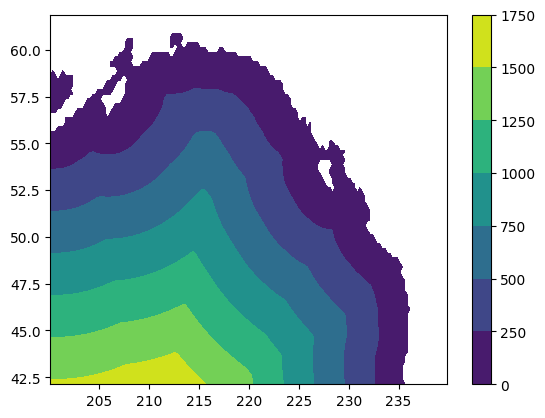

In [21]:
# display the map
plt.contourf(xx,yy,D)
plt.colorbar()
da=xr.DataArray(data=D,name='distance',dims=['lat','lon'],coords={'lat':y,'lon':x})
ds0=da.to_dataset()
ds0.to_netcdf('distance_from_nearest_land.nc')

In [22]:
#
# read in the data from netCDF files
#
Years = np.arange(2003,2022,1)
Months= np.arange(4,10,1)
Nt = np.size(Years)*np.size(Months)
data=np.zeros((Ns+2,Nt,Nmax))*np.nan
time=np.empty(Nt,dtype='datetime64[ns]')
data2d=np.zeros((Ns+2,Nt,Nmax,50))*np.nan
#
for n,YYYY in enumerate(Years):
    for m,MON in enumerate(Months):
        tcnt = m+n*np.size(Months)
        DAY=15    
        date = datetime(YYYY, MON, DAY)
        fn = date.strftime(f"output/Anticyc_{domain}_{Lcutoff}_{sshmin}_%Y%m%d.nc")
        ds = xr.open_dataset(fn)
        time[int(tcnt)]=date
        #
        for l in range(Ns):
            tmp1=np.zeros(Nmax)*np.nan
            tmp2=np.zeros((Nmax,50))*np.nan
            # read in the data from netCDF files
            tmp = ds[vars_keep[l]].to_numpy()
            Nobs=np.size(tmp)
            tmp1[:Nobs]=tmp
            # store them in the data array
            data[l,int(tcnt),:]=tmp1
        #
        # calculate the distance to the nearest land
        for l in range(Nobs):
            lon0=ds.longitude[l].to_numpy()
            lat0=ds.latitude[l].to_numpy()
            dist=ds0.distance.sel(lon=lon0,method='nearest').sel(lat=lat0,method='nearest').to_numpy()
            data[Ns,int(tcnt),l]=dist
        # record the NPP values
        fn = date.strftime(f"output/NPP_Anticyc_{domain}_{Lcutoff}_{sshmin}_%Y%m%d.npy")
        tmp=np.load(fn)
        data[Ns+1,int(tcnt),:Nobs]=tmp
        for l in range(Ns2d):
            tmp2=np.zeros((Nmax,50))*np.nan
            # read in the data from netCDF files
            tmp = ds[vectors[l]].to_numpy()
            Nobs=np.size(tmp[:,0])
            tmp2[:Nobs,:]=tmp
            # store them in the data array
            data2d[l,int(tcnt),:,:]=tmp2

In [23]:
# generate a single netCDF file
obs=np.arange(0,Nmax,1)
Ncnt=np.arange(0,50,1)
#
da = xr.DataArray(data=np.squeeze(data[Ns+1,:,:]),name='NPP',
                  dims=['time','obs'],coords={'time':time,'obs':obs})
ds = da.to_dataset()
ds['dist_to_coast']=xr.DataArray(data=np.squeeze(data[Ns,:,:]),
                  dims=['time','obs'],coords={'time':time,'obs':obs})
for n in range(Ns):
    ds[vars_keep[n]]=xr.DataArray(data=np.squeeze(data[n,:,:]),
                  dims=['time','obs'],coords={'time':time,'obs':obs})
for n in range(Ns2d):
    ds[vectors[n]]=xr.DataArray(data=np.squeeze(data2d[n,:,:,:]),
                  dims=['time','obs','Ncnt'],coords={'time':time,'obs':obs,'Ncnt':Ncnt})

In [24]:
ds.to_netcdf(f'Anticyc_{domain}_{Lcutoff}_{sshmin}.nc')

In [27]:
# Cyclonic eddies

In [28]:
#
# read in the data from netCDF files
#
Years = np.arange(2003,2022,1)
Months= np.arange(4,10,1)
Nt = np.size(Years)*np.size(Months)
data=np.zeros((Ns+2,Nt,Nmax))*np.nan
data2d=np.zeros((Ns+2,Nt,Nmax,50))*np.nan
time=np.empty(Nt,dtype='datetime64[ns]')
#
for n,YYYY in enumerate(Years):
    for m,MON in enumerate(Months):
        tcnt = m+n*np.size(Months)
        DAY=15    
        date = datetime(YYYY, MON, DAY)
        fn = date.strftime(f"output/Cyc_{domain}_{Lcutoff}_{sshmin}_%Y%m%d.nc")
        ds = xr.open_dataset(fn)
        time[int(tcnt)]=date
        #
        for l in range(Ns):
            tmp1=np.zeros(Nmax)*np.nan
            # read in the data from netCDF files
            tmp = ds[vars_keep[l]].to_numpy()
            Nobs=np.size(tmp)
            tmp1[:Nobs]=tmp
            # store them in the data array
            data[l,int(tcnt),:]=tmp1
        #
        # calculate the distance to the nearest land
        for l in range(Nobs):
            lon0=ds.longitude[l].to_numpy()
            lat0=ds.latitude[l].to_numpy()
            dist=ds0.distance.sel(lon=lon0,method='nearest').sel(lat=lat0,method='nearest').to_numpy()
            data[Ns,int(tcnt),l]=dist
        # record the NPP values
        fn = date.strftime(f"output/NPP_Cyc_{domain}_{Lcutoff}_{sshmin}_%Y%m%d.npy")
        tmp=np.load(fn)
        data[Ns+1,int(tcnt),:Nobs]=tmp
        for l in range(Ns2d):
            tmp2=np.zeros((Nmax,50))*np.nan
            # read in the data from netCDF files
            tmp = ds[vectors[l]].to_numpy()
            Nobs=np.size(tmp[:,0])
            tmp2[:Nobs,:]=tmp
            # store them in the data array
            data2d[l,int(tcnt),:,:]=tmp2

In [29]:
# generate a single netCDF file
da = xr.DataArray(data=np.squeeze(data[Ns+1,:,:]),name='NPP',
                  dims=['time','obs'],coords={'time':time,'obs':obs})
ds = da.to_dataset()
ds['dist_to_coast']=xr.DataArray(data=np.squeeze(data[Ns,:,:]),
                  dims=['time','obs'],coords={'time':time,'obs':obs})
for n in range(Ns):
    ds[vars_keep[n]]=xr.DataArray(data=np.squeeze(data[n,:,:]),
                  dims=['time','obs'],coords={'time':time,'obs':obs})
for n in range(Ns2d):
    ds[vectors[n]]=xr.DataArray(data=np.squeeze(data2d[n,:,:,:]),
                  dims=['time','obs','Ncnt'],coords={'time':time,'obs':obs,'Ncnt':Ncnt})

In [30]:
ds.to_netcdf(f'Cyc_{domain}_{Lcutoff}_{sshmin}.nc')

In [31]:
ds

<xarray.Dataset>
Dimensions:                        (time: 114, obs: 100, Ncnt: 50)
Coordinates:
  * time                           (time) datetime64[ns] 2003-04-15 ... 2021-...
  * obs                            (obs) int64 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * Ncnt                           (Ncnt) int64 0 1 2 3 4 5 ... 45 46 47 48 49
Data variables: (12/25)
    NPP                            (time, obs) float64 12.27 -12.0 ... nan nan
    dist_to_coast                  (time, obs) float64 1.389e+03 604.3 ... nan
    amplitude                      (time, obs) float64 0.0313 0.0258 ... nan nan
    effective_area                 (time, obs) float64 1.818e+10 ... nan
    effective_contour_height       (time, obs) float64 -0.01 -0.01 ... nan nan
    effective_contour_shape_error  (time, obs) float64 9.0 8.0 34.0 ... nan nan
    ...                             ...
    speed_radius                   (time, obs) float64 7.635e+04 ... nan
    effective_contour_latitude     (time, obs, Ncnt) float64 42.41 42.42 ... nan
    effective_contour_longitude    (time, obs, Ncnt) float64 216.1 216.0 ... nan
    speed_contour_latitude         (time, obs, Ncnt) float64 42.41 42.42 ... nan
    speed_contour_longitude        (time, obs, Ncnt) float64 216.1 216.0 ... nan
    uavg_profile                   (time, obs, Ncnt) float64 0.0827 ... nan